In [1]:
import time
from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

from dhg import Hypergraph
from dhg.data import *
from dhg.models import *
from dhg.random import set_seed
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator


/home/ad/miniconda/envs/hy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### #neighbors distribution

In [2]:

data = CoauthorshipCora()
G = Hypergraph(data["num_vertices"], data["edge_list"])
print(G)
# train_mask = data["train_mask"]
# val_mask = data["val_mask"]
# test_mask = data["test_mask"]

# # 设置随机种子，以确保结果可复现
random_seed = 0

node_idx = [i for i in range(data['num_vertices'])]

labels = data["labels"]
y = labels.numpy()
# 将idx_test划分为训练（60%）、验证（20%）和测试（20%）集
idx_train, idx_temp, train_y, tem_y = train_test_split(node_idx, y, test_size=0.5, random_state=random_seed, stratify=y)
idx_val, idx_test, val_y, test_y = train_test_split(idx_temp, tem_y, test_size=0.5, random_state=random_seed, stratify=tem_y)
# 将idx_test划分为训练（50%）、验证（25%）和测试（25%）集
# idx_train, idx_temp = train_test_split(node_idx, test_size=0.5, random_state=random_seed)
# idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=random_seed)

# 确保划分后的集合没有重叠
assert len(set(idx_train) & set(idx_val)) == 0
assert len(set(idx_train) & set(idx_test)) == 0
assert len(set(idx_val) & set(idx_test)) == 0

train_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
val_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
test_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# idx_train = np.where(train_mask)[0]
# idx_val = np.where(val_mask)[0]
# idx_test = np.where(test_mask)[0]

# v_deg= G.D_v
# X = v_deg.to_dense()/torch.max(v_deg.to_dense())
X = data["features"]
lbls = data["labels"]
print('X dim:', X.shape)
print('labels:', len(torch.unique(lbls)))


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

set_seed(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])


num_epochs = 200


X, lbls = X.to(device), lbls.to(device)
G = G.to(device)

net = HyperGCN(X.shape[1], 64, data["num_classes"])
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = StepLR(optimizer, step_size=int(num_epochs/5), gamma=0.1)
net = net.to(device)
print(f'net: {net}')

Hypergraph(num_v=2708, num_e=970)
X dim: torch.Size([2708, 1433])
labels: 7
net: HyperGCN(
  (layers): ModuleList(
    (0): HyperGCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=1433, out_features=64, bias=True)
    )
    (1): HyperGCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=64, out_features=7, bias=True)
    )
  )
)


In [3]:
net.load_state_dict(torch.load('../src_new2/model/hypergcn_coauthorcora_hid64_0104.pth'))

net.eval()
with torch.no_grad():
    new_embs = net(X, G)

new_embs.shape

torch.Size([2708, 7])

In [4]:
for edge in G.e[0]:
    if len(edge) < 2:
        print(edge)
    

In [5]:
edge = G.e[0]
edge

[(235, 355),
 (1133, 1666, 1888),
 (783, 785),
 (570, 1058, 1211, 1246),
 (523, 717),
 (543, 603, 1163, 1355),
 (52,
  140,
  251,
  323,
  535,
  865,
  932,
  1024,
  1505,
  1823,
  2476,
  2487,
  2555,
  2560,
  2580),
 (1580, 2329),
 (701, 1019, 1659, 1869),
 (62, 270, 339, 495, 573, 723, 773, 1137, 1983, 2078, 2406, 2425, 2474, 2566),
 (269, 2415, 2438, 2530),
 (19, 424, 571, 1762, 2331, 2495, 2694),
 (487, 538, 1822, 2281),
 (877, 1010, 1578, 1651),
 (40, 114, 171, 488, 761, 798, 1124, 1390, 1566, 1567, 1661, 1888, 2053, 2054),
 (52, 701, 1019, 1539),
 (1538, 1724),
 (52, 2487, 2555),
 (141, 1184, 1959),
 (681, 1391, 2437),
 (1325, 2047),
 (476, 1787, 1871, 2385, 2676),
 (357, 803, 1439),
 (86, 249, 652),
 (516, 2268, 2445, 2569, 2579),
 (691, 1213, 1557, 1958, 2058),
 (1889, 2648),
 (290, 1098, 1719, 1911, 1925, 1984, 2087, 2133, 2199, 2206, 2259, 2261, 2379),
 (1737, 1936),
 (930, 948, 1043, 1254, 1282),
 (400, 701, 1019, 1189),
 (54, 129, 1175, 1204, 1628, 1728, 2309, 2334),

In [6]:
for v in G.v:
    print(v)
min(G.v), max(G.v)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(0, 2707)

In [7]:
deg_list = []
subnodes = []
for v in G.v:
    count = 0
    for e in edge:
        if v in e:
            count+=1
        # for k in e:
        #     if k not in subnodes:
        #         subnodes.append(k)
    deg_list.append(count)
min(deg_list), max(deg_list), sum(deg_list)/len(deg_list)

(0, 15, 1.6074593796159526)

In [8]:
subnodes = list(set(list(subnodes)))
len(subnodes)

0

In [9]:
for v in G.v:
    if v not in subnodes:
        print(v)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
deg_list

[1,
 1,
 2,
 3,
 1,
 0,
 2,
 1,
 4,
 3,
 1,
 0,
 1,
 1,
 4,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 4,
 5,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 4,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 4,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 4,
 3,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 4,
 0,
 2,
 0,
 1,
 1,
 1,
 3,
 0,
 1,
 3,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 0,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 6,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 4,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 3,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 2,
 3,
 2,
 1,
 1,
 3,
 2,
 2,
 3,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 3,
 0,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,


In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# A = G.H @ G.H.T
# print('adjacent matrix:', A)

# # 将稀疏张量转换为标准的邻接矩阵表示
# adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# # 计算每个节点的度（关联的邻居节点数）
# degree_list = adj_matrix.to_dense().sum(dim=1)
# degree_list = degree_list.cpu().numpy().tolist()
# degree_list = [int(i) for i in degree_list]

# min(degree_list), max(degree_list), sum(degree_list)/len(degree_list)



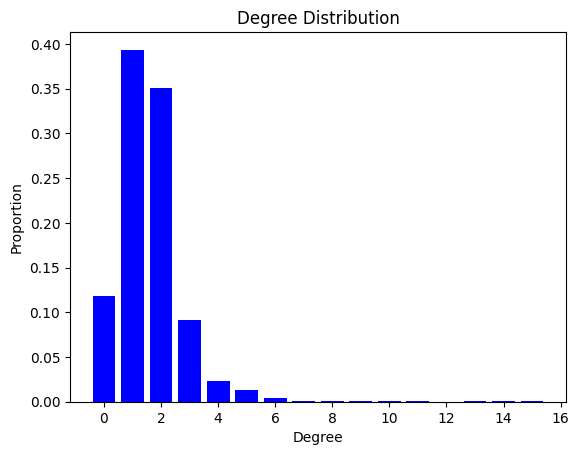

In [12]:
# 使用Counter计算值的分布
degree_distribution = Counter(deg_list)

# 提取度数和对应的出现次数
degrees, counts = zip(*degree_distribution.items())

# 计算占比
total_counts = sum(counts)
proportions = [count / total_counts for count in counts]

# print(counts,total_counts,sum(proportions))
# 创建柱状图
plt.bar(degrees, proportions, color='blue', align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.title('Degree Distribution')

# 显示图形
plt.show()

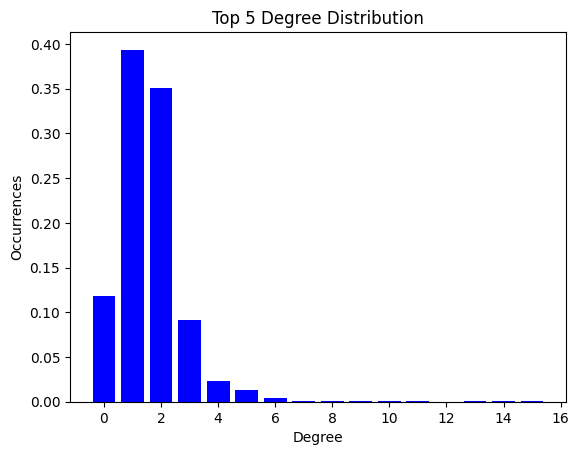

In [13]:
# 获取排名前5的度数和对应的出现次数
top_degrees = sorted(degree_distribution.items(), key=lambda x: x[1], reverse=True)
top_degrees, top_counts = zip(*top_degrees)



# 计算占比
top_total_counts = sum(top_counts)
top_proportions = [count / top_total_counts for count in top_counts]


# 创建柱状图
plt.bar(top_degrees, top_proportions, color='blue', align='center')


# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Top 5 Degree Distribution')

# 显示图形
plt.show()

In [14]:
len(deg_list)

2708

In [15]:
new_embs.shape

torch.Size([2708, 7])

In [16]:
#Validate and Test
output = new_embs
output, lbls = output, labels
_, predicted = torch.max(output, 1)
# 将predicted结果转换为numpy数组
predicted_array = predicted.cpu().numpy()

# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = lbls

In [17]:
from sklearn.metrics import accuracy_score

def get_neighbor_acc(x, y1, y2):
    # 创建一个字典用于存储每个度序列取值对应的预测结果和真实标签
    grouped_data = {}
    for degree, pred, true_label in zip(x, y1, y2):
        if degree not in grouped_data:
            grouped_data[degree] = {'y1': [], 'y2': []}
        grouped_data[degree]['y1'].append(pred)
        grouped_data[degree]['y2'].append(true_label)

    # 计算每个分组下的预测准确性
    accuracy_per_group = {}
    for degree, data in grouped_data.items():
        accuracy_per_group[degree] = accuracy_score(data['y1'], data['y2'])

    # # 打印每个分组下的预测准确性
    # for degree, accuracy in accuracy_per_group.items():
    #     print(f"Degree {degree}: Accuracy = {accuracy:.2f}")
    # 按照degree从小到大排序，并打印前5个分组的预测准确性
    sorted_accuracy = sorted(accuracy_per_group.items(), key=lambda x: x[0])  # 按照度degree排序
    top_5_accuracy = sorted_accuracy[:10]  # 前5个分组

    for degree, accuracy in top_5_accuracy:
        print(f"Degree {degree}: Accuracy = {accuracy:.2f}")

    return degree, accuracy

num_neibors, accs = get_neighbor_acc(deg_list, predicted_labels, true_labels)

Degree 0: Accuracy = 0.84
Degree 1: Accuracy = 0.88
Degree 2: Accuracy = 0.88
Degree 3: Accuracy = 0.90
Degree 4: Accuracy = 0.90
Degree 5: Accuracy = 0.89
Degree 6: Accuracy = 1.00
Degree 7: Accuracy = 1.00
Degree 8: Accuracy = 1.00
Degree 9: Accuracy = 0.00


In [18]:
### 上面是baseline针对全部节点的情况，只针对测试集合的情况
#Validate and Test
test_output = new_embs
test_output, test_lbls = test_output[idx_test], labels[idx_test]
_, test_predicted = torch.max(test_output, 1)
# 将predicted结果转换为numpy数组
test_predicted_array = test_predicted.cpu().numpy()

# 将numpy数组转换为列表
test_predicted_labels = test_predicted_array.tolist()
test_true_labels = test_lbls

In [19]:
test_degree_list = [deg_list[i] for i in idx_test]
test_num_neibors, test_accs = get_neighbor_acc(test_degree_list, test_predicted_labels, test_true_labels)

Degree 0: Accuracy = 0.86
Degree 1: Accuracy = 0.89
Degree 2: Accuracy = 0.88
Degree 3: Accuracy = 0.88
Degree 4: Accuracy = 0.94
Degree 5: Accuracy = 0.92
Degree 6: Accuracy = 1.00
Degree 7: Accuracy = 1.00
Degree 9: Accuracy = 0.00
Degree 11: Accuracy = 0.00


#### 测试我们的方法

In [20]:
from __future__ import division
from __future__ import print_function
import argparse
import numpy as np
import scipy.sparse as sp
import torch
import sys
import copy
import random
import torch.nn.functional as F
import torch.optim as optim
import hgnn_cvae_pretrain_new_cora
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import time
from copy import deepcopy
# from config import config
from utils import accuracy, normalize_features
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, f1_score
from dhg import Hypergraph
from dhg.data import *
from dhg.models import *
from dhg.random import set_seed
from sklearn.model_selection import train_test_split

from hgcn.models import HGNN, LAHGCN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from dhg import Hypergraph
from dhg.data import CoauthorshipCora
# from data_load_utils import *
# from dhg.models import HGNN, LAHGCN
# from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

from utils import accuracy, normalize_features, micro_f1, macro_f1, sparse_mx_to_torch_sparse_tensor, normalize_adj
from hgcn import *
from hgcn.models import HGNN, LAHGCN
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
exc_path = sys.path[0]
import os, torch, numpy as np
import hgnn_cvae_pretrain_new_citeseer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [21]:
args = argparse.Namespace(
    samples=4,
    concat=8,
    runs=1,
    latent_size=10,
    dataset='coauthorcora',
    seed=0,
    epochs=1000,
    lr=0.01,
    weight_decay=5e-4,
    hidden=64,
    dropout=0.5,
    batch_size=128,
    tem=0.5,
    lam=1.0,
    pretrain_epochs=8,
    pretrain_lr=0.05,
    conditional=True,
    update_epochs=20,
    num_models=100,
    warmup=200,
    use_mediator=False
)

torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.cuda = torch.cuda.is_available()

print('args\n', args)


args
 Namespace(samples=4, concat=8, runs=1, latent_size=10, dataset='coauthorcora', seed=0, epochs=1000, lr=0.01, weight_decay=0.0005, hidden=64, dropout=0.5, batch_size=128, tem=0.5, lam=1.0, pretrain_epochs=8, pretrain_lr=0.05, conditional=True, update_epochs=20, num_models=100, warmup=200, use_mediator=False, cuda=True)


In [23]:
features = X.cpu().numpy()
features_normalized = normalize_features(features)
features_normalized = torch.FloatTensor(features_normalized)

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

model = LAHyperGCN(concat=args.concat+1,
                  in_channels=X.shape[1],
                  hid_channels=args.hidden,
                  num_classes=labels.max().item() + 1,
                  use_mediator=args.use_mediator,
                  use_bn=False,
                  drop_rate=args.dropout)
model.load_state_dict(torch.load('../src_new2/model/lahypergcn_coauthorcora_hid64_0107.pth'))
# model = LAHGCN(concat=args.concat+1,
#                 in_channels=features.shape[1],
#                 hid_channels=args.hidden,
#                 num_classes=labels.max().item() + 1,
#                 use_bn=False,
#                 drop_rate=args.dropout)
# model.load_state_dict(torch.load('lahgcn_cociteseer_hid64_C2_0106.pth'))
X, lbls = X.to(device), lbls.to(device)
hg = G.to(device)
net = model.to(device)

exc_path = sys.path[0]

# cvae_model = torch.load("{}/model/{}_0104.pkl".format(exc_path, args.dataset))
cvae_model = torch.load("../src_new2/model/coauthorcora_0104.pkl")
cvae_model = cvae_model.to(device)

def get_augmented_features(concat):
    X_list = []
    cvae_features = torch.tensor(features, dtype=torch.float32).to(device)
    for _ in range(concat):
        z = torch.randn([cvae_features.size(0), args.latent_size]).to(device)
        augmented_features = cvae_model.inference(z, cvae_features)
        augmented_features = hgnn_cvae_pretrain_new_cora.feature_tensor_normalize(augmented_features).detach()
        if args.cuda:
            X_list.append(augmented_features.to(device))
        else:
            X_list.append(augmented_features)
    return X_list

X_list = get_augmented_features(args.concat)


our_new_embs = model(X_list+[features_normalized],hg)
our_new_embs.shape

torch.Size([2708, 7])

In [24]:
#Validate and Test
our_output = our_new_embs
our_output, our_lbls = our_output, labels
_, our_predicted = torch.max(our_output, 1)
# 将predicted结果转换为numpy数组
our_predicted_array = our_predicted.cpu().numpy()

# 将numpy数组转换为列表
our_predicted_labels = our_predicted_array.tolist()
our_true_labels = our_lbls

In [25]:

num_neibors, accs = get_neighbor_acc(deg_list, our_predicted_labels, our_true_labels)

Degree 0: Accuracy = 0.82
Degree 1: Accuracy = 0.89
Degree 2: Accuracy = 0.88
Degree 3: Accuracy = 0.91
Degree 4: Accuracy = 0.92
Degree 5: Accuracy = 0.92
Degree 6: Accuracy = 1.00
Degree 7: Accuracy = 0.67
Degree 8: Accuracy = 1.00
Degree 9: Accuracy = 0.00


In [26]:
### 上面是我们的方法针对全部节点的情况，只针对测试集合的情况
#Validate and Test
our_test_output = our_new_embs
our_test_output, our_test_lbls = our_test_output[idx_test], labels[idx_test]
_, our_test_predicted = torch.max(our_test_output, 1)
# 将predicted结果转换为numpy数组
our_test_predicted_array = our_test_predicted.cpu().numpy()

# 将numpy数组转换为列表
our_test_predicted_labels = our_test_predicted_array.tolist()
our_test_true_labels = our_test_lbls

our_test_degree_list = [deg_list[i] for i in idx_test]
our_test_num_neibors, our_test_accs = get_neighbor_acc(our_test_degree_list, our_test_predicted_labels, our_test_true_labels)

Degree 0: Accuracy = 0.83
Degree 1: Accuracy = 0.88
Degree 2: Accuracy = 0.90
Degree 3: Accuracy = 0.88
Degree 4: Accuracy = 0.94
Degree 5: Accuracy = 0.92
Degree 6: Accuracy = 1.00
Degree 7: Accuracy = 1.00
Degree 9: Accuracy = 0.00
Degree 11: Accuracy = 0.00


In [27]:
our_test_degree_list == test_degree_list

True

#### Figure 1

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

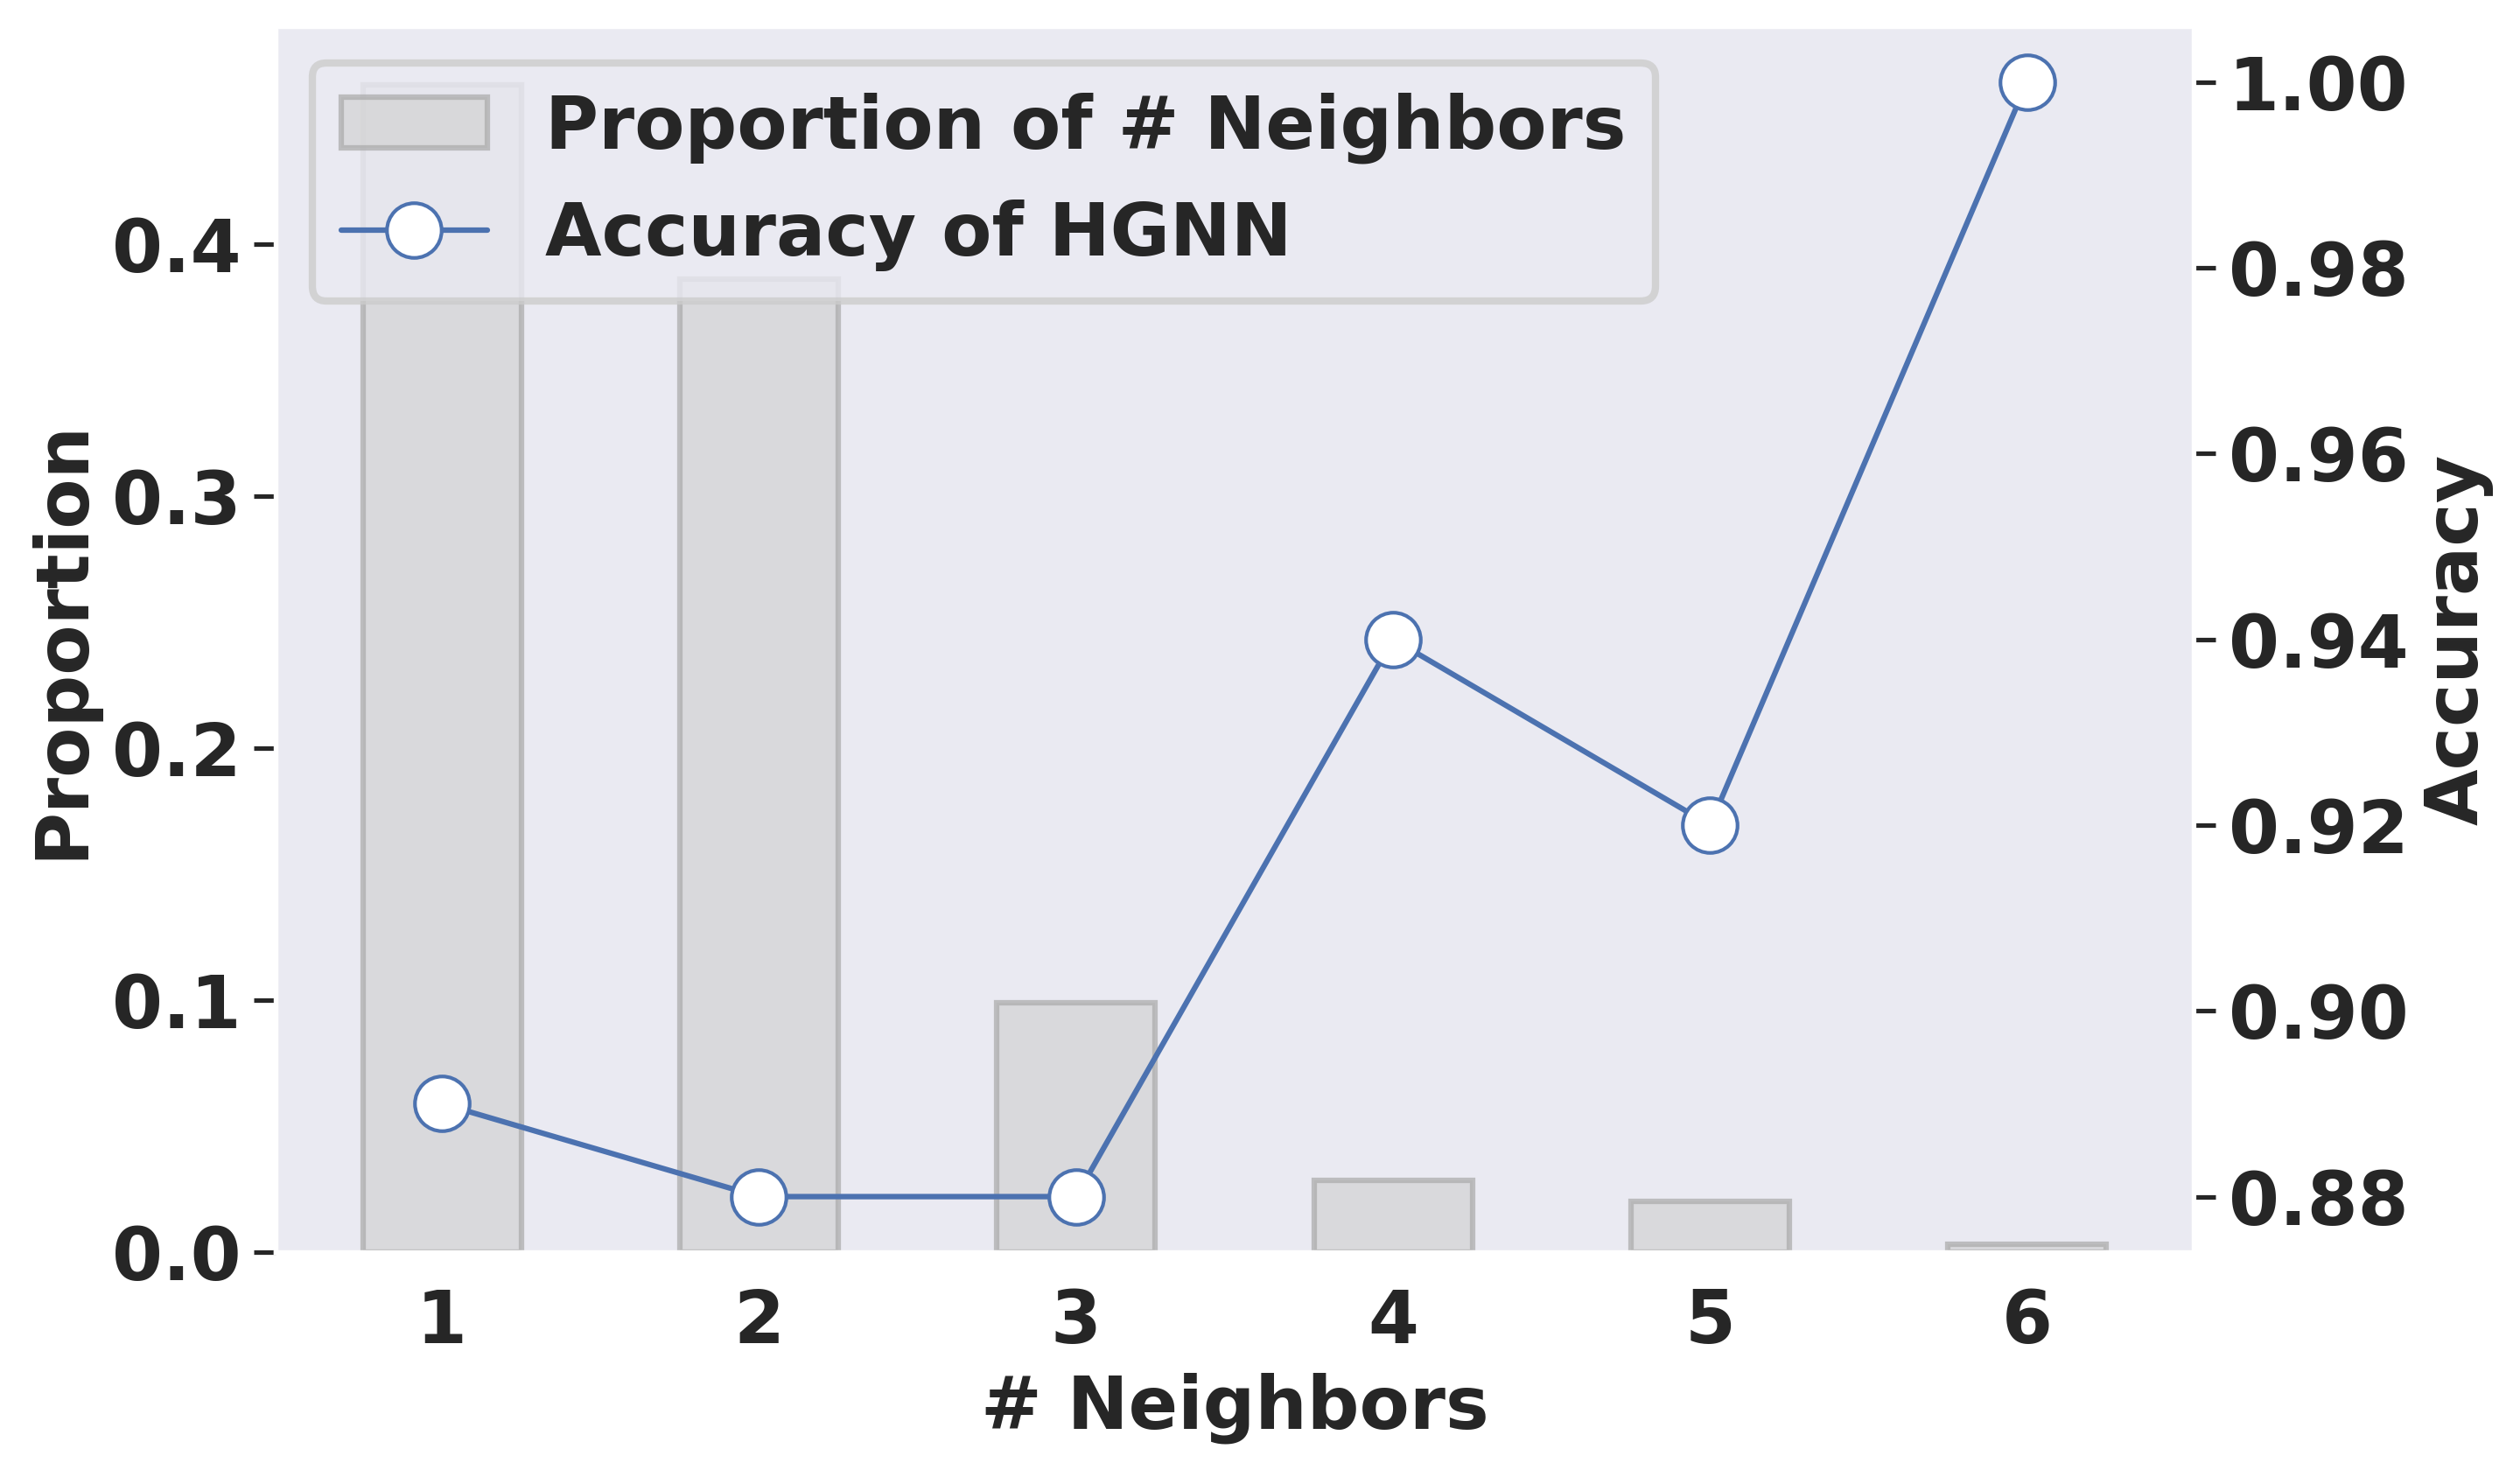

In [272]:
test_deg_list = [value for key, value in enumerate(test_degree_list) if 0<value <= 6]
# acc1_list = [0.66, 0.90, 0.85, 0.83, 0.82]
# acc2_list = [0.68, 0.92, 0.88, 0.78, 0.88]
acc2_list = [0.89, 0.88, 0.88, 0.94, 0.92,1.0]
acc1_list = [0.89, 0.89, 0.90, 0.94, 0.92,1.0]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 20

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=20, fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=20, fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
# line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='GAFFER', markersize=12)
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=15, markerfacecolor='white')

ax2.set_ylabel('Accuracy', fontsize=20, fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line2], ['Proportion of # Neighbors','Accuracy of HGNN'], loc='best', fancybox=True, shadow=False, ncol=1, fontsize=20)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# 关闭背景网格线
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.savefig('res/neighrs_acc4.pdf')
plt.savefig('res/neighrs_acc4.png')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

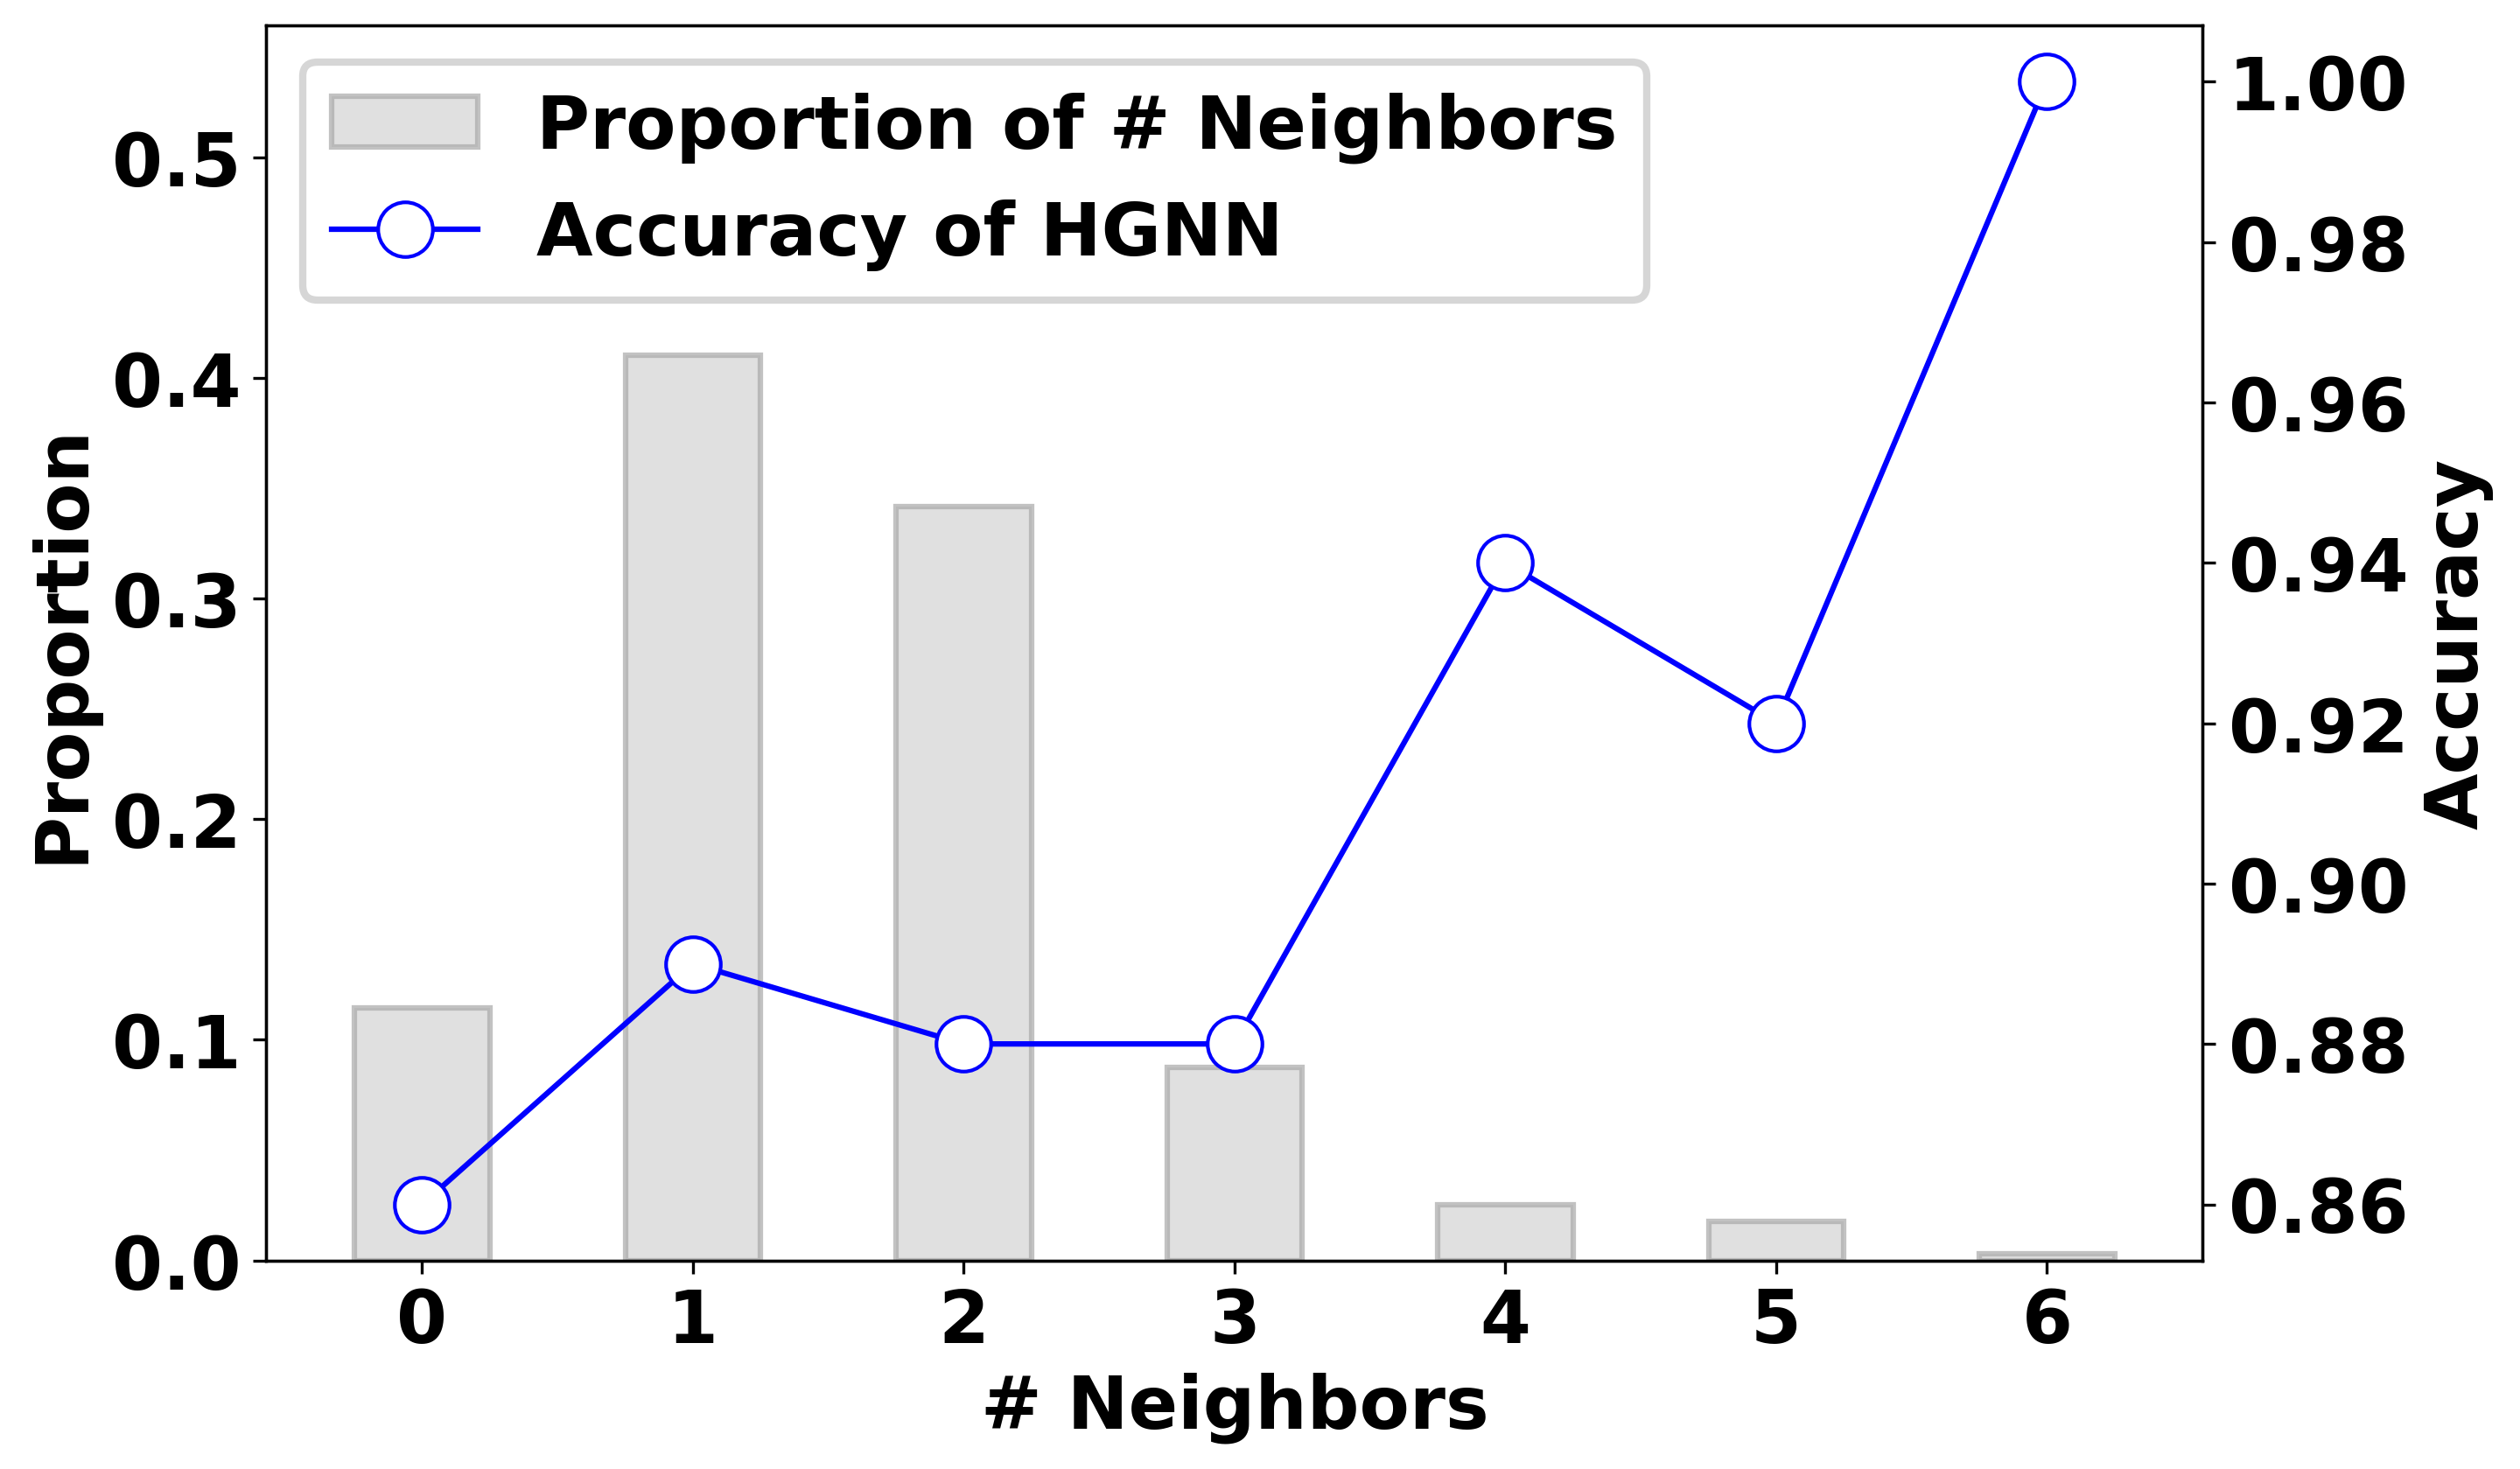

In [24]:
test_deg_list = [value for key, value in enumerate(test_degree_list) if 0<=value <= 6]
# acc1_list = [0.66, 0.90, 0.85, 0.83, 0.82]
# acc2_list = [0.68, 0.92, 0.88, 0.78, 0.88]
acc2_list = [0.86, 0.89, 0.88, 0.88, 0.94, 0.92,1.0]
acc1_list = [0.84, 0.89, 0.89, 0.90, 0.94, 0.92,1.0]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list+[0]))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 20

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=20, fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=20, fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
# line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='GAFFER', markersize=12)
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=15, markerfacecolor='white')

ax2.set_ylabel('Accuracy', fontsize=20, fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line2], ['Proportion of # Neighbors','Accuracy of HGNN'], loc='best', fancybox=True, shadow=False, ncol=1, fontsize=20)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# 获取当前左侧 Y 轴的刻度范围
ymin, ymax = ax1.get_ylim()

# 根据条形图的高度调整刻度范围
padding = 0.3 * (ymax - ymin)  # 设置额外的填充量，避免遮挡
ax1.set_ylim(ymin , ymax + padding)

# 关闭背景网格线
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.savefig('figs/neighrs_hypergcn_acc_cacora.pdf')
# plt.savefig('res/neighrs_acc4.png')
plt.show()

In [270]:
test_deg_list

[1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 4,
 3,
 3,
 2,
 4,
 1,
 1,
 3,
 1,
 3,
 2,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 4,
 2,
 2,
 3,
 1,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 4,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 4,
 1,
 1,
 2,
 1,
 2,
 3,
 5,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 5,
 3,
 2,
 2,
 1,
 1,
 1,
 5,
 2,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 5,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 6,
 1,
 1,
 1,
 1,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 1,
 5,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

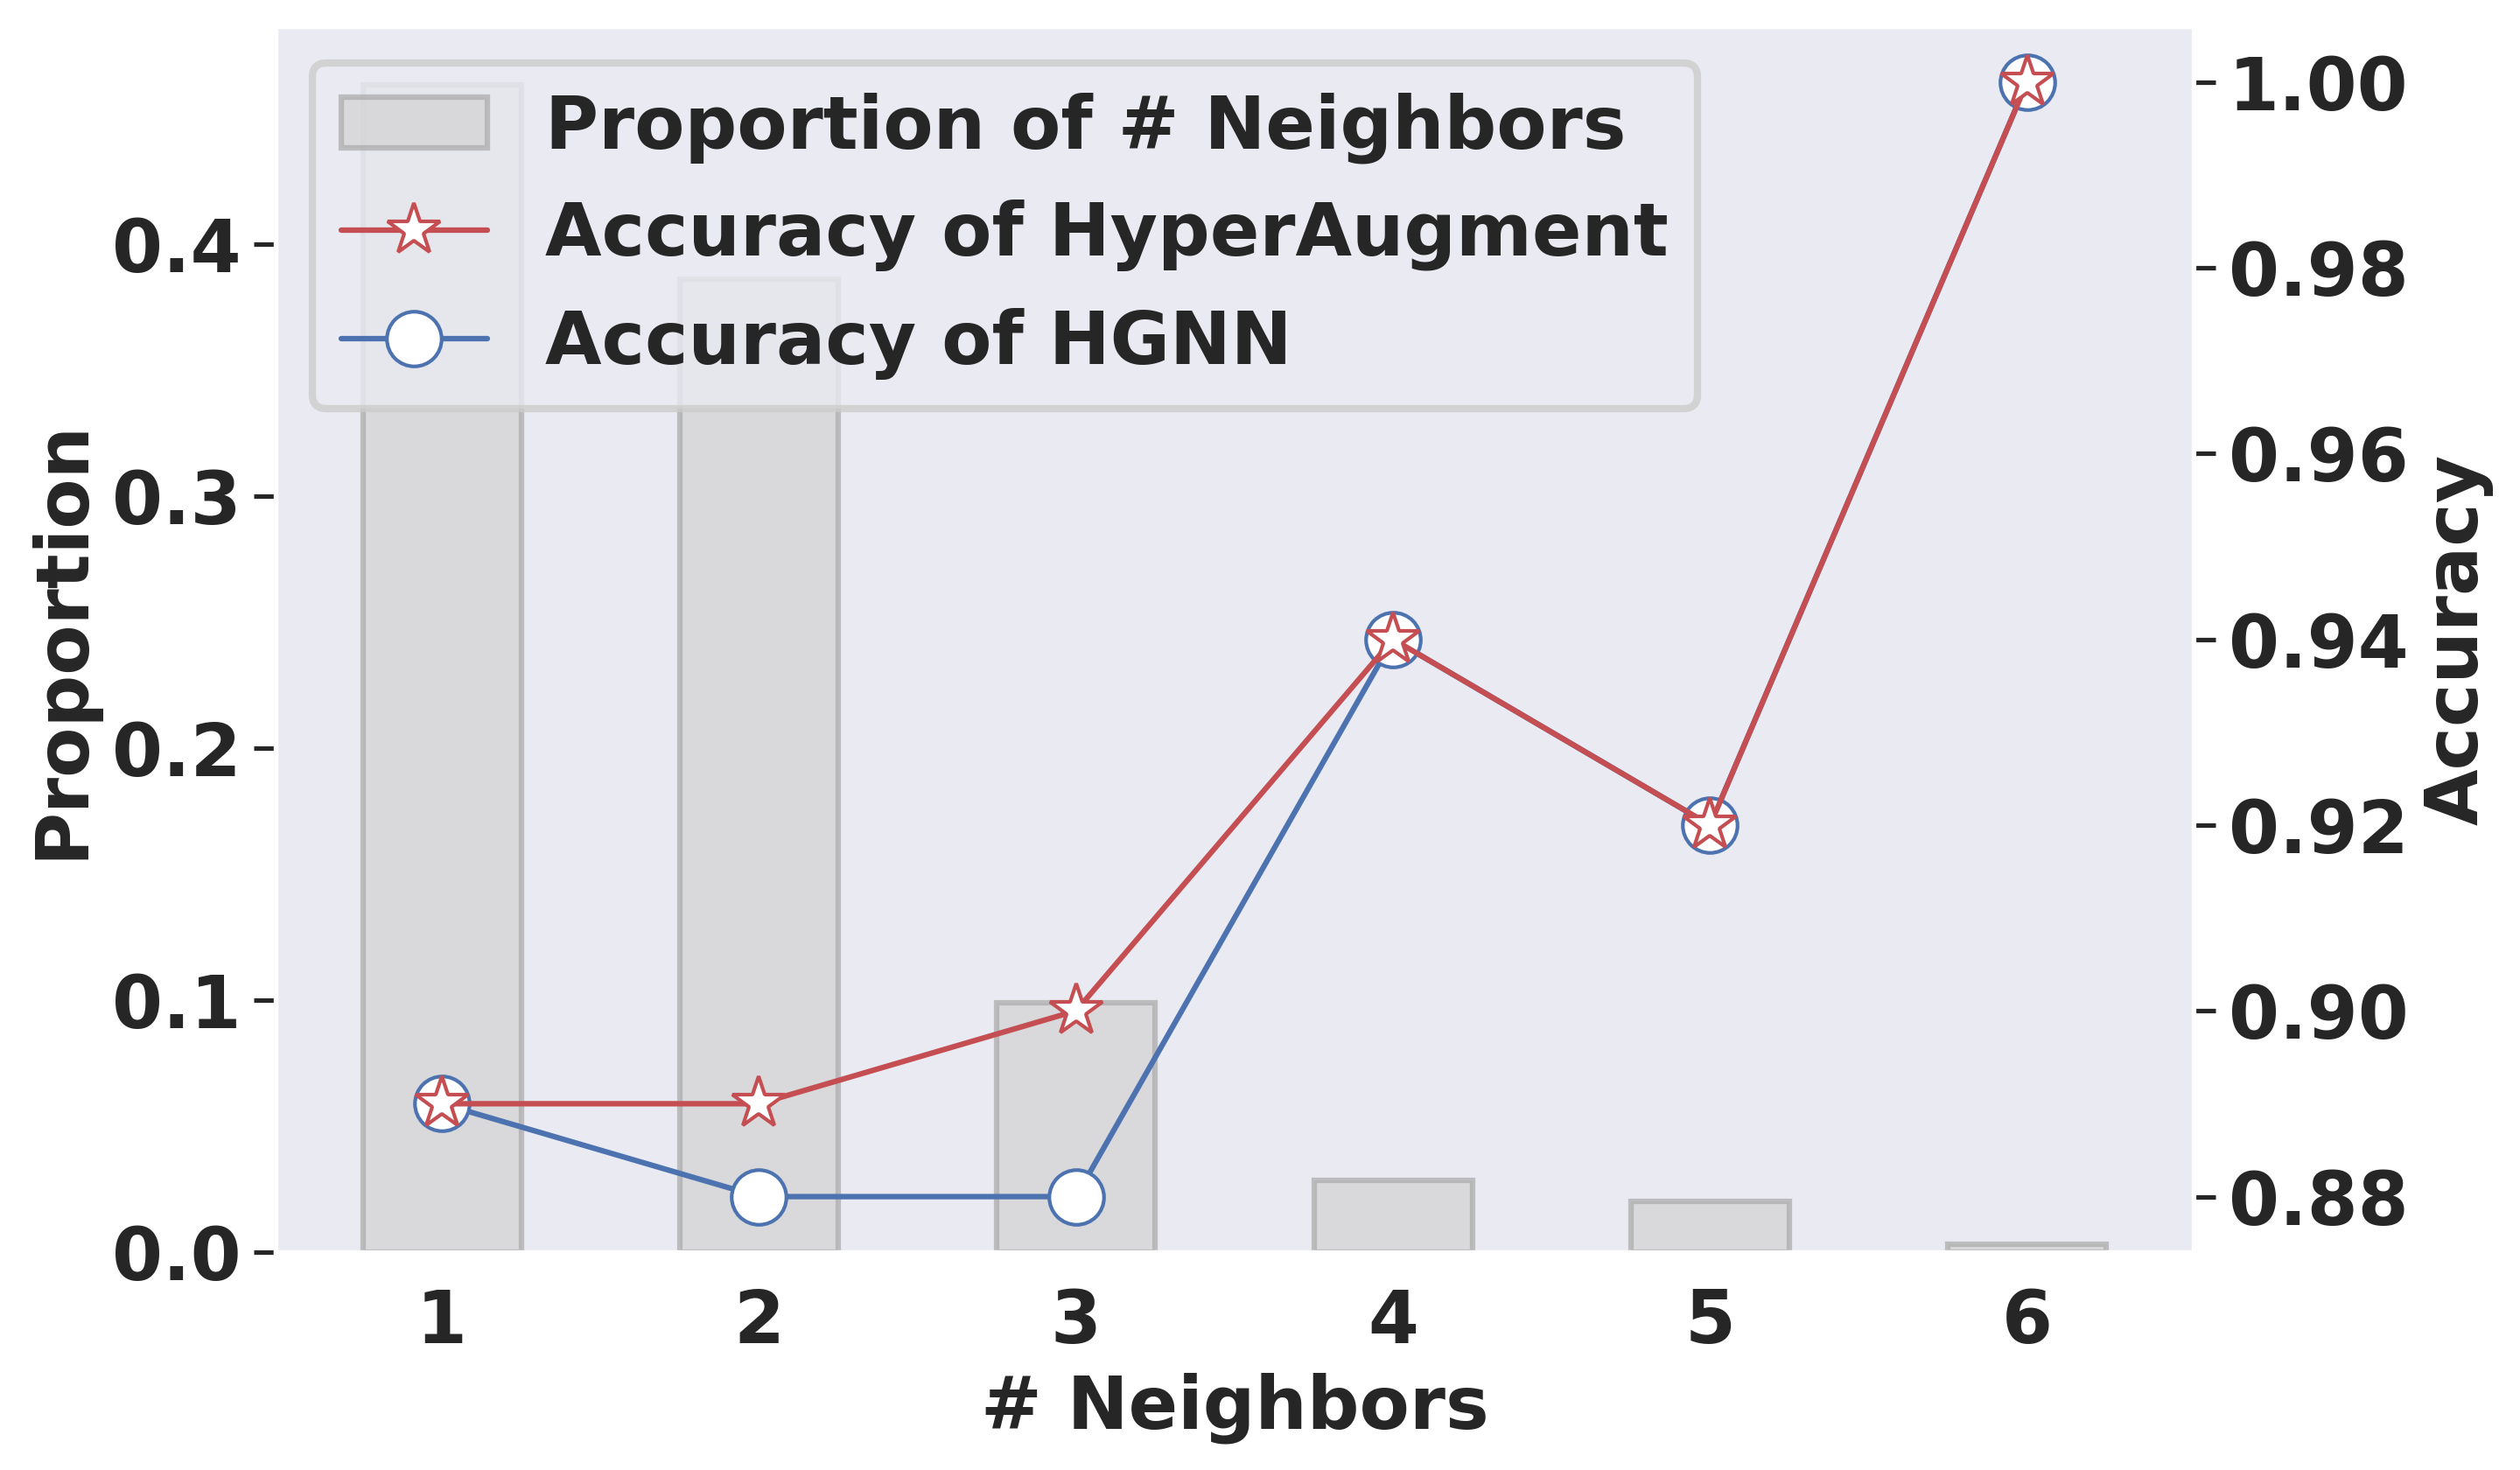

In [273]:

import matplotlib.pyplot as plt
import numpy as np

test_deg_list = [value for key, value in enumerate(test_degree_list) if 0<value <= 6]
# acc1_list = [0.66, 0.90, 0.85, 0.83, 0.82]
# acc2_list = [0.68, 0.92, 0.88, 0.78, 0.88]
acc2_list = [0.89, 0.88, 0.88, 0.94, 0.92, 1.0]
# acc1_list = [0.90, 0.90, 0.86, 0.96, 0.92]
acc1_list = [0.89, 0.89, 0.90, 0.94, 0.92,1.0]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 20

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=20, fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=20, fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=15, markerfacecolor='white')
line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='HyperAugment', markersize=15, markerfacecolor='white')


ax2.set_ylabel('Accuracy', fontsize=20, fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line1, line2], ['Proportion of # Neighbors','Accuracy of HyperAugment','Accuracy of HGNN'], loc='best', fancybox=True, shadow=False, ncol=1, fontsize=20)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# 关闭背景网格线
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
plt.savefig('res/neighrs_acc4_1.pdf')
plt.savefig('res/neighrs_acc4_1.png')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

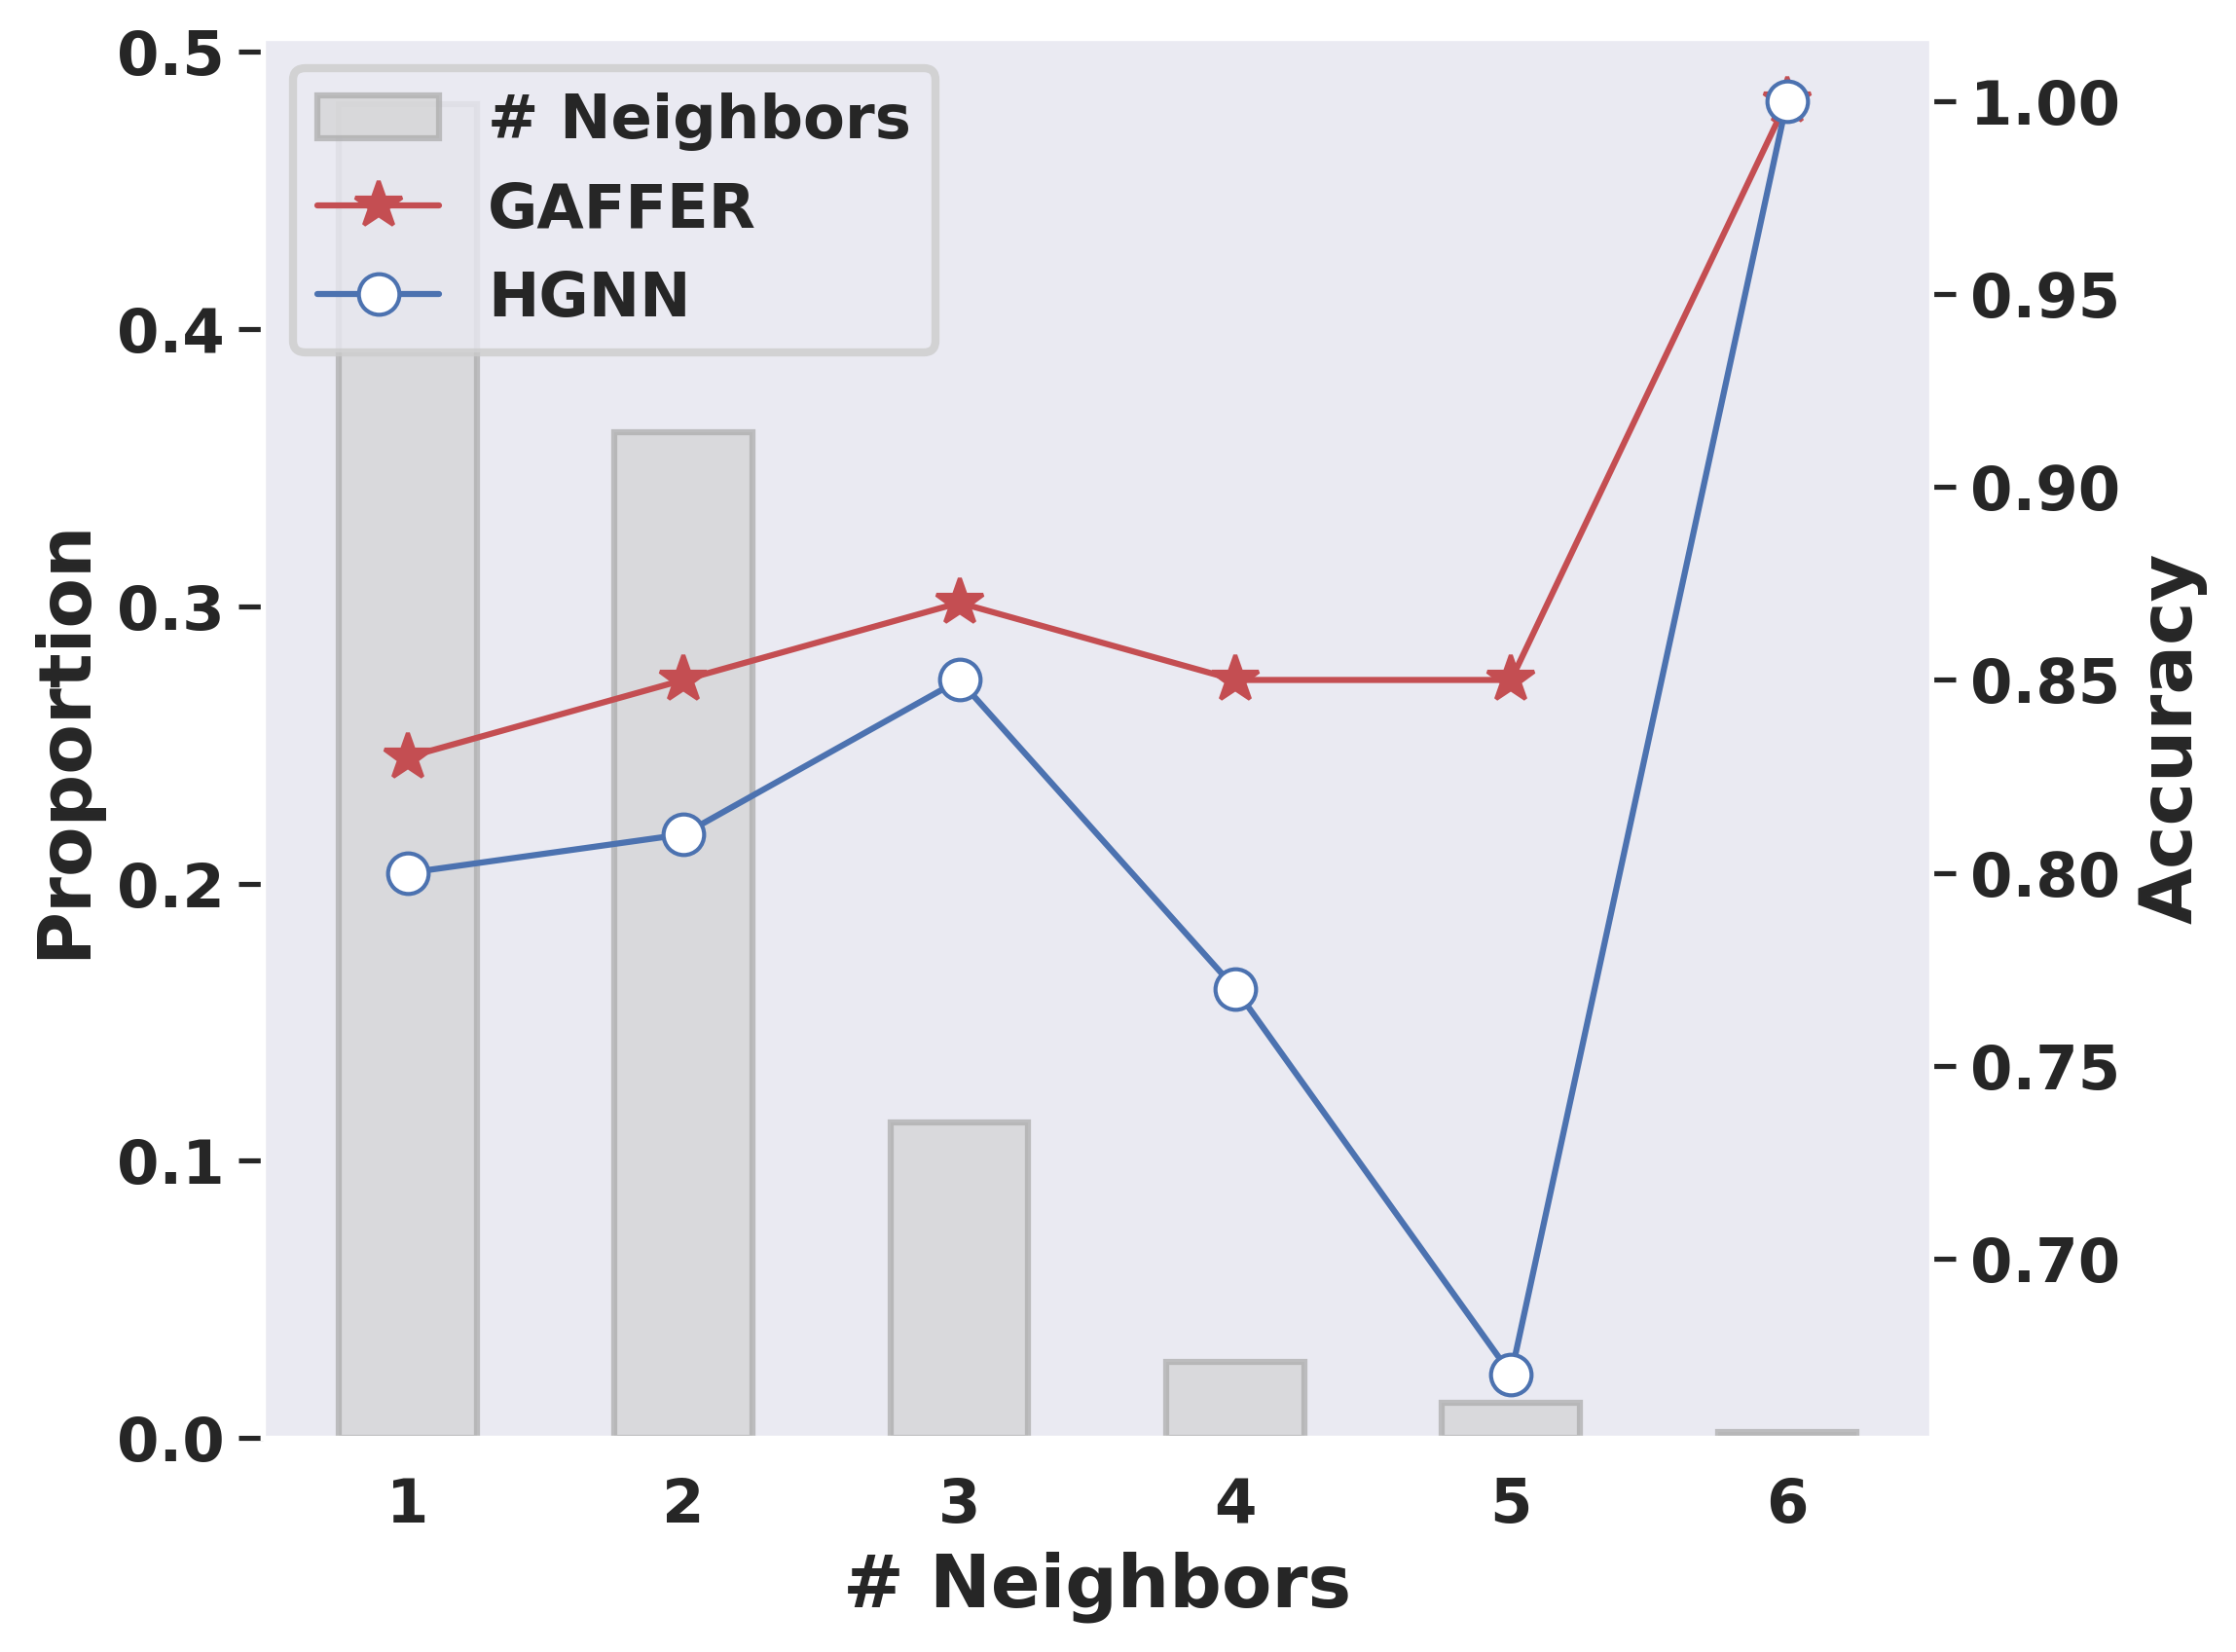

In [84]:
test_deg_list = [value for key, value in enumerate(test_degree_list) if 0<value <= 6]
# acc1_list = [0.66, 0.90, 0.85, 0.83, 0.82]
# acc2_list = [0.68, 0.92, 0.88, 0.78, 0.88]
# acc2_list = [0.88, 0.86, 0.71, 0.77, 0.65]
# acc1_list = [0.90, 0.90, 0.86, 0.96, 0.92]
acc2_list = [0.80, 0.81, 0.85, 0.77, 0.67, 1.0]
acc1_list = [0.83, 0.85, 0.87, 0.85, 0.85, 1.0]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 18

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=18, fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=18, fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='GAFFER', markersize=12)
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=10, markerfacecolor='white')

ax2.set_ylabel('Accuracy', fontsize=18, fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line1, line2], ['# Neighbors', 'GAFFER', 'HGNN'], loc='best', fancybox=True, shadow=False, ncol=1, fontsize=15)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# 关闭背景网格线
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
# plt.savefig('figs/neighrs_acc1.pdf')
# plt.savefig('figs/neighrs_acc1.png')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

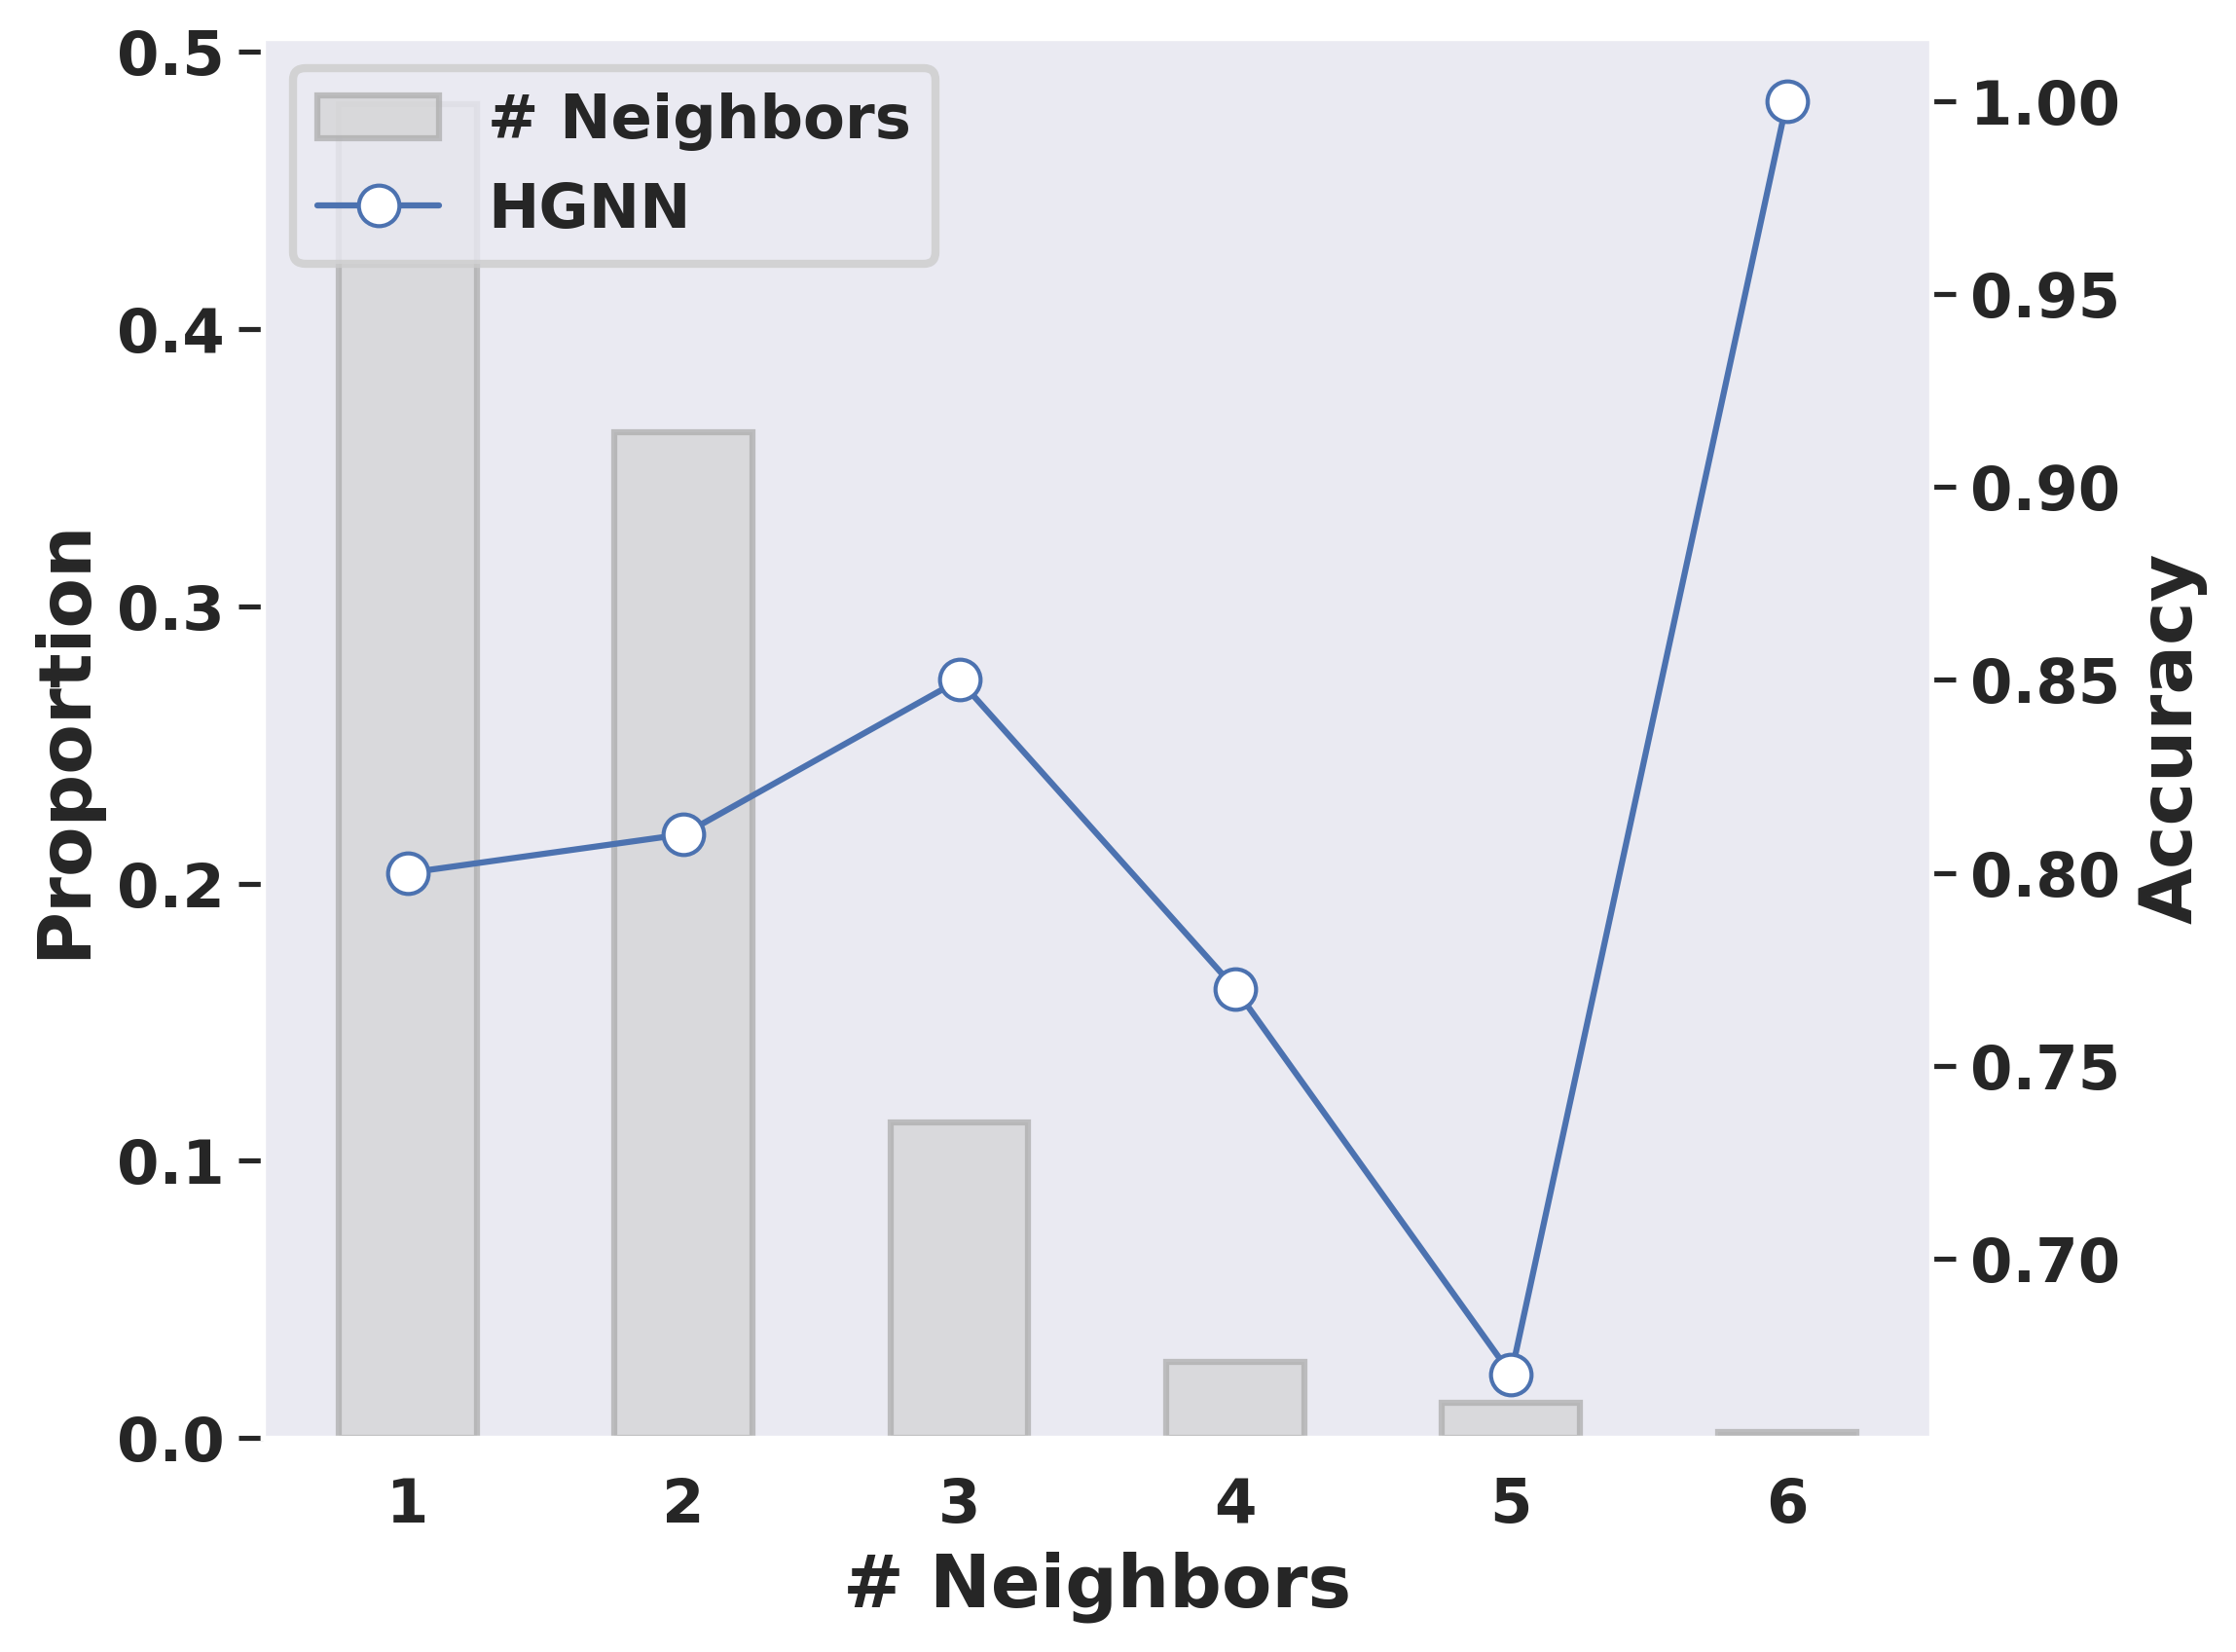

In [85]:
test_deg_list = [value for key, value in enumerate(test_degree_list) if 0<value <= 6]
# acc1_list = [0.66, 0.90, 0.85, 0.83, 0.82]
# acc2_list = [0.68, 0.92, 0.88, 0.78, 0.88]
# acc2_list = [0.88, 0.86, 0.71, 0.77, 0.65]
# acc1_list = [0.90, 0.90, 0.86, 0.96, 0.92]
acc2_list = [0.80, 0.81, 0.85, 0.77, 0.67, 1.0]
acc1_list = [0.83, 0.85, 0.87, 0.85, 0.85, 1.0]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 18

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=18, fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=18, fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
# line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='GAFFER', markersize=12)
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=10, markerfacecolor='white')

ax2.set_ylabel('Accuracy', fontsize=18, fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line2], ['# Neighbors', 'HGNN'], loc='best', fancybox=True, shadow=False, ncol=1, fontsize=15)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# 关闭背景网格线
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
# plt.savefig('figs/neighrs_acc1.pdf')
# plt.savefig('figs/neighrs_acc1.png')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

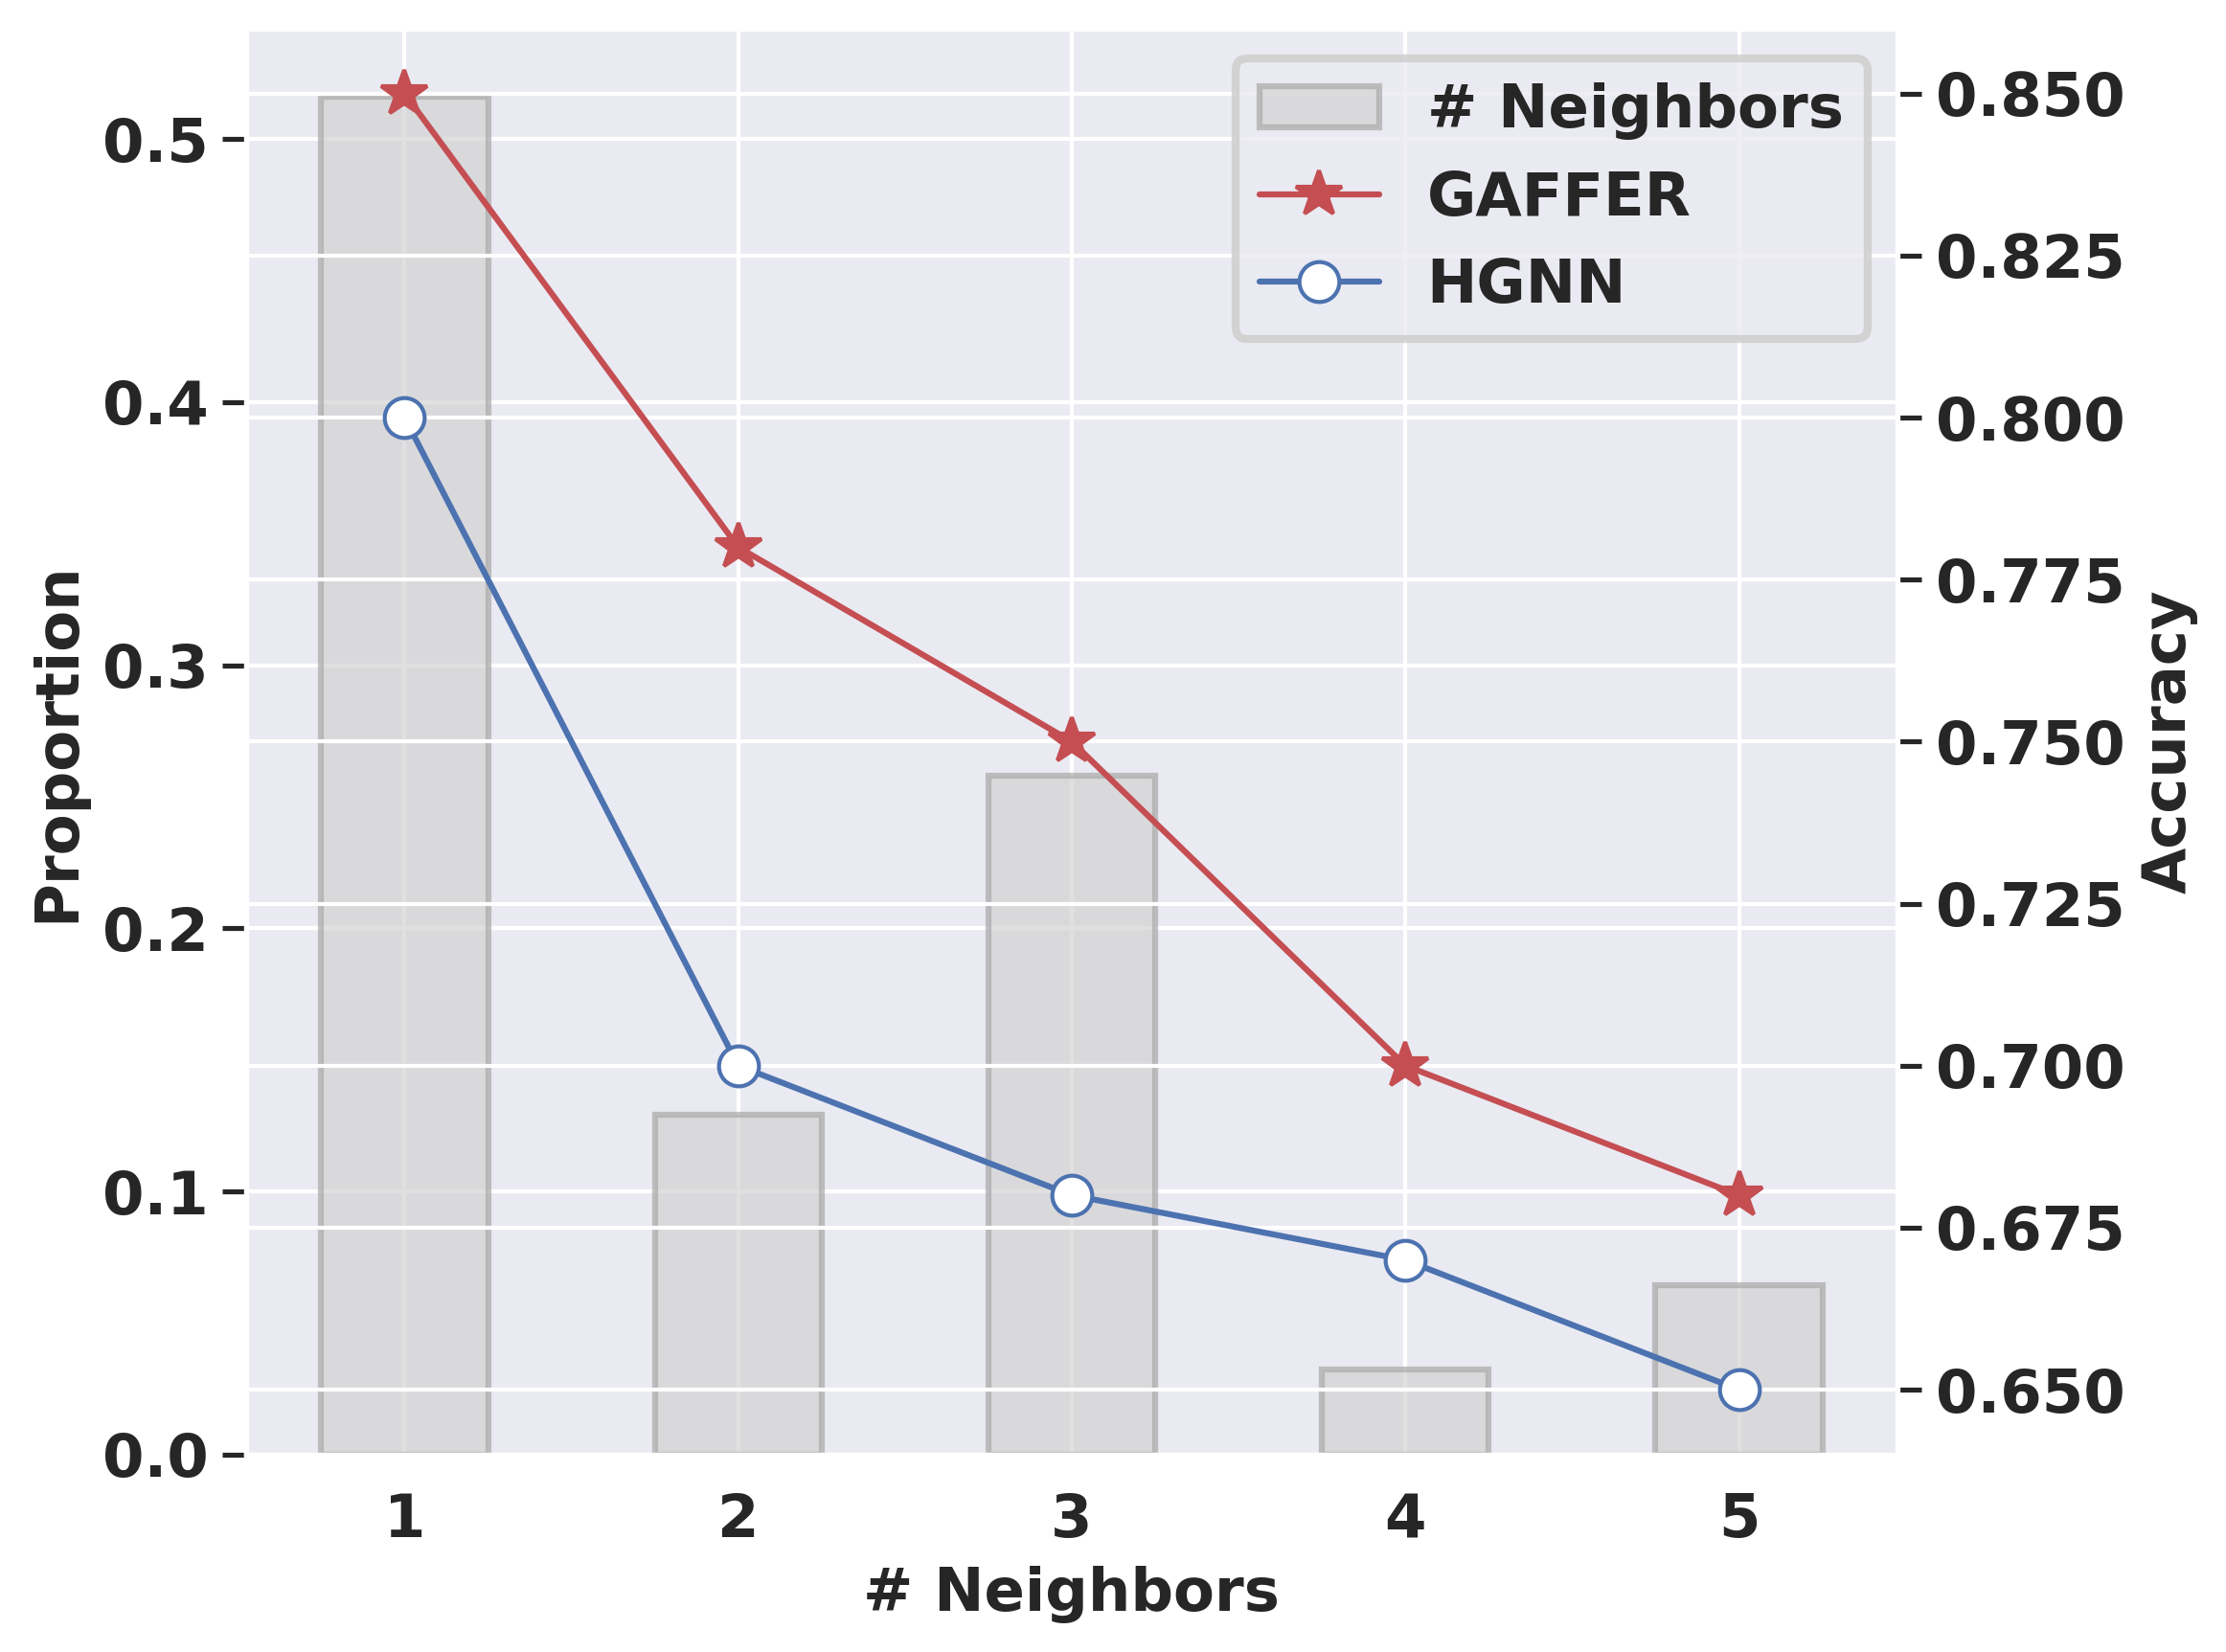

In [101]:
### 图1
import matplotlib.pyplot as plt
import numpy as np

test_deg_list = [1, 2, 3, 1, 1, 1, 2, 3, 3, 4, 5, 5, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1,3,3,3,2,1,1,1]
acc1_list = [0.85, 0.78, 0.75, 0.7, 0.68]
acc2_list = [0.8, 0.7, 0.68, 0.67, 0.65]

# 统计test_deg_list中每个元素的出现次数，计算占比
deg_counts = {i: test_deg_list.count(i) for i in set(test_deg_list)}
total_deg = sum(deg_counts.values())
deg_percentage = {key: val / total_deg for key, val in deg_counts.items()}

# 获取不重复的 test_deg_list 序列作为 x 轴
unique_deg = sorted(set(test_deg_list))

# 设置全局字体加粗和字号
plt.rcParams['font.family'] = 'Arial'  # 设置使用Arial字体
plt.rcParams['font.weight'] = 'bold'   # 设置normal-不加粗;bold-加粗
plt.rcParams['font.size'] = 15

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)

# 绘制左侧 Y 轴（占比）
bars = ax1.bar(unique_deg, [deg_percentage.get(deg, 0) for deg in unique_deg], width=0.5, color='lightgrey', alpha=0.7)
ax1.set_xlabel('# Neighbors', fontsize=15,fontweight='bold')
ax1.set_ylabel('Proportion', fontsize=15,fontweight='bold')

# 创建右侧 Y 轴（acc）
ax2 = ax1.twinx()

# 绘制右侧 Y 轴（acc1_list 和 acc2_list）
line1, = ax2.plot(unique_deg[:len(acc1_list)], acc1_list, 'r*-', label='GAFFER', markersize=12)
line2, = ax2.plot(unique_deg[:len(acc2_list)], acc2_list, 'bo-', label='HGNN', markersize=10,markerfacecolor='white')

ax2.set_ylabel('Accuracy', fontsize=15,fontweight='bold')

# 调整条形图边缘颜色为深灰色
for bar in bars:
    bar.set_edgecolor('darkgrey')
    bar.set_linewidth(1.5)  # 设置边缘粗细为2

# 构建图例并设置为竖直摆放
legend = plt.legend([bars, line1, line2], ['# Neighbors', 'GAFFER', 'HGNN'], loc='upper right', fancybox=True, shadow=False, ncol=1, fontsize=15)
# legend = plt.legend([bars, line1, line2], ['Test Deg', 'Acc1', 'Acc2'], loc='best', fontsize=15)
legend.get_frame().set_linewidth(2)  # 设置图例边框线宽度为0
# 调整坐标轴刻度标签的字体大小
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

#### 计算相似性

In [86]:

import torch.nn.functional as F

def column_cosine_similarity(tensor1, tensor2):
    # 按列归一化
    norm_tensor1 = F.normalize(tensor1, p=2, dim=1)
    norm_tensor2 = F.normalize(tensor2, p=2, dim=1)
    
    # 计算余弦相似性
    similarity = F.cosine_similarity(norm_tensor1, norm_tensor2, dim=0)
    
    return similarity



cos_sim = column_cosine_similarity(embs, our_embs)
print('cociteseer feature similarity:\n')
print('cos_sim:', cos_sim,'avg of cos_sim:', torch.mean(cos_sim).item())

# #MSE 
# # 计算差值
# diff = embs-our_embs

# # 计算平方
# squared_diff = diff**2

# # 计算均值
# mse = torch.mean(squared_diff)

# # 输出 MSE
# print(mse.item())

cociteseer feature similarity:

cos_sim: tensor([0.9094, 0.8563, 0.8384, 0.9370, 0.8844, 0.9091, 0.8153],
       grad_fn=<SumBackward1>) avg of cos_sim: 0.8785519003868103


In [85]:
our_embs.shape, X.shape

(torch.Size([2708, 7]), torch.Size([2708, 1433]))

In [75]:
i = 0
for edge in G.e[0]:
    if len(edge) <= 5:
        i+=1

i, i/len(G.e[0])

(773, 0.7969072164948454)

In [76]:
G.H.to_dense()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [77]:
from scipy.sparse import csr_matrix
import gc

def adjacency_matrix(hg, s=1, weight=False):
        r"""
        The :term:`s-adjacency matrix` for the dual hypergraph.

        Parameters
        ----------
        s : int, optional, default 1

        Returns
        -------
        adjacency_matrix : scipy.sparse.csr.csr_matrix

        """
        
        tmp_H = hg.H.to_dense().numpy()
        A = tmp_H @ (tmp_H.T)
        A[np.diag_indices_from(A)] = 0
        if not weight:
            A = (A >= s) * 1

        del tmp_H
        gc.collect()

        return csr_matrix(A)

In [78]:
A = adjacency_matrix(G, s=1, weight=False)


In [79]:
# 计算度序列
degree_sequence = np.array(A.sum(axis=1)).flatten()

# 打印度序列
print("Degree sequence:", degree_sequence)

Degree sequence: [ 4  1 27 ...  6 13  3]


In [80]:
remove_index = [i for i,e in enumerate(degree_sequence) if e == 0]

remove_index[:10], len(remove_index), len(degree_sequence)-len(remove_index)

([5, 11, 17, 29, 34, 44, 49, 50, 53, 59], 320, 2388)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


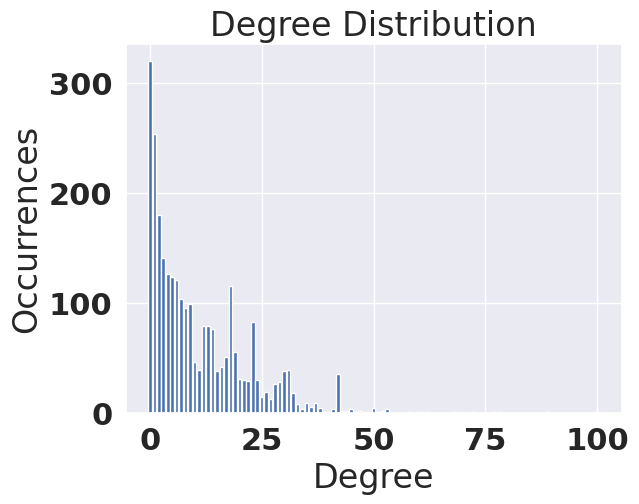

In [81]:
import matplotlib.pyplot as plt
from collections import Counter

# 使用Counter计算值的分布
degree_distribution = Counter(degree_sequence)

# 提取度数和对应的出现次数
degrees, counts = zip(*degree_distribution.items())

# 创建柱状图
plt.bar(degrees, counts, align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Degree Distribution')

# 显示图形
plt.show()

In [82]:

import numpy as np
import matplotlib.pyplot as plt

import numpy as np


# A = G.H @ G.H.T
print(A)

# # 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# # 计算每个节点的度
# degree_list = adj_matrix.to_dense().sum(dim=1)
# degree_list = degree_list.cpu().numpy().tolist()

  (0, 8)	1
  (0, 384)	1
  (0, 1267)	1
  (0, 1671)	1
  (1, 1721)	1
  (2, 57)	1
  (2, 60)	1
  (2, 173)	1
  (2, 295)	1
  (2, 298)	1
  (2, 306)	1
  (2, 321)	1
  (2, 370)	1
  (2, 466)	1
  (2, 473)	1
  (2, 552)	1
  (2, 554)	1
  (2, 562)	1
  (2, 564)	1
  (2, 720)	1
  (2, 738)	1
  (2, 775)	1
  (2, 875)	1
  (2, 1019)	1
  (2, 1189)	1
  :	:
  (2703, 2494)	1
  (2703, 2666)	1
  (2704, 1797)	1
  (2705, 343)	1
  (2705, 765)	1
  (2705, 1831)	1
  (2705, 1832)	1
  (2705, 1836)	1
  (2705, 2688)	1
  (2706, 163)	1
  (2706, 540)	1
  (2706, 543)	1
  (2706, 603)	1
  (2706, 1046)	1
  (2706, 1121)	1
  (2706, 1138)	1
  (2706, 1214)	1
  (2706, 1344)	1
  (2706, 1345)	1
  (2706, 1420)	1
  (2706, 1640)	1
  (2706, 1752)	1
  (2707, 547)	1
  (2707, 1274)	1
  (2707, 1577)	1


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# 将稀疏张量转换为标准的邻接矩阵表示
# adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# # 计算每个节点的度
# degree_list = adj_matrix.to_dense().sum(dim=1)
# degree_list = degree_list.cpu().numpy().tolist()
# degree_list

NameError: name 'adj_matrix' is not defined

In [ ]:
degree_counts

{1: {'ones': 5, 'zeros': 46, 'total': 51},
 2: {'ones': 14, 'zeros': 51, 'total': 65},
 0: {'ones': 74, 'zeros': 281, 'total': 355},
 5: {'ones': 5, 'zeros': 32, 'total': 37},
 4: {'ones': 11, 'zeros': 26, 'total': 37},
 3: {'ones': 12, 'zeros': 34, 'total': 46}}

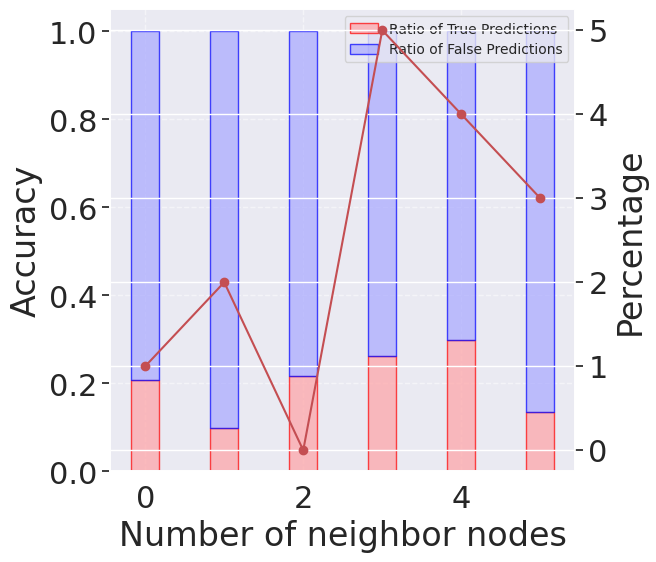

In [ ]:
degree_list = degree_sequence


# 从文件中读取预测结果
predicted_array = np.loadtxt('res/bkhgnn_predicted_cociteseer_hid64_0104.txt', dtype=int)
# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = labels[test_mask].cpu().numpy().tolist()


predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# 计算每个节点的ACC
trues = (predicted_labels == true_labels).astype(int)
errors = [1 if value == 0 else 0 for value in trues]

degree_counts = {}
filtered_data = [(degree, value1, value2) for degree, value1, value2 in zip(degree_list, trues, errors) if 0 <= degree <= 5]

# Populate the dictionary
for degree, value1, value2 in filtered_data:
    if degree not in degree_counts:
        degree_counts[degree] = {'ones': 0, 'zeros': 0, 'total': 0}
    degree_counts[degree]['ones'] += value1
    degree_counts[degree]['zeros'] += value2
    degree_counts[degree]['total'] += 1

# Calculate the probabilities
degree_probabilities_list1 = [degree_counts.get(degree, {'ones': 0})['ones'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(0,6)]
degree_probabilities_list2 = [degree_counts.get(degree, {'zeros': 0})['zeros'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(0,6)]

# Plot the results
width = 0.35
fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(np.arange(0,6), degree_probabilities_list1, width, label='Ratio of True Predictions', color='#FFA2A5', edgecolor='#FF0000',alpha=0.7)
ax.bar(np.arange(0,6), degree_probabilities_list2, width, label='Ratio of False Predictions', color='#A7A7FF', edgecolor='#0000FF',alpha=0.7, bottom=degree_probabilities_list1)
ax.set_xlabel('Number of neighbor nodes')
ax.set_ylabel('Accuracy')
ax.grid(True, linestyle='--', alpha=0.5)

# 创建第二个纵坐标轴（右边）
ax2 = ax.twinx()
ax2.set_ylabel('Percentage')
ax2.plot(np.arange(0,6), list(degree_counts)[:6], color='r', marker='o',label='Percentage')

# ax.set_title('Ratio distribution of True and False predictions')
ax.legend(fontsize=10)
# plt.savefig('figs/hgnn_true_predic_cociteseer_hid64_0104.pdf')

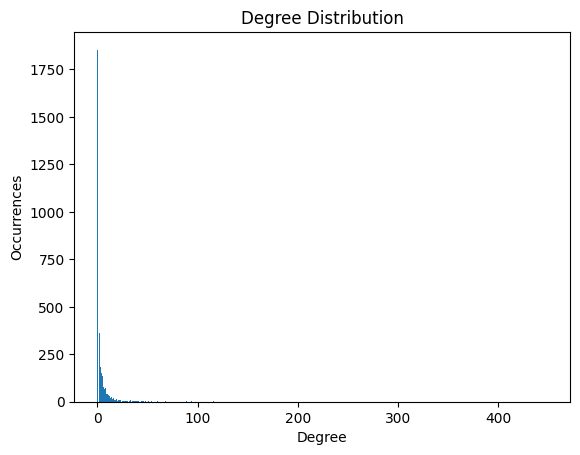

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# 使用Counter计算值的分布
degree_distribution = Counter(degree_list)

# 提取度数和对应的出现次数
degrees, counts = zip(*degree_distribution.items())

# 创建柱状图
plt.bar(degrees, counts, align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Degree Distribution')

# 显示图形
plt.show()

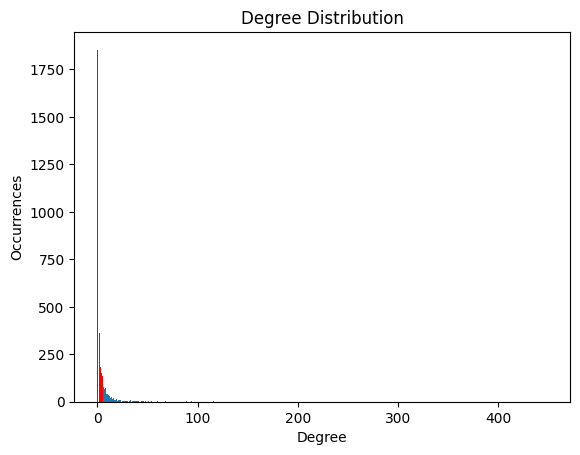

In [ ]:
# 获取排名前5的度数和对应的出现次数
top_degrees = sorted(degree_distribution.items(), key=lambda x: x[1], reverse=True)[:5]
top_degrees, top_counts = zip(*top_degrees)

# 创建柱状图
plt.bar(degrees, counts, align='center')

# 突出显示排名前5的度数
plt.bar(top_degrees, top_counts, color='red', align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Degree Distribution')

# 显示图形
plt.show()


In [ ]:
top_degrees[:5]

(0.0, 2.0, 3.0, 4.0, 5.0)

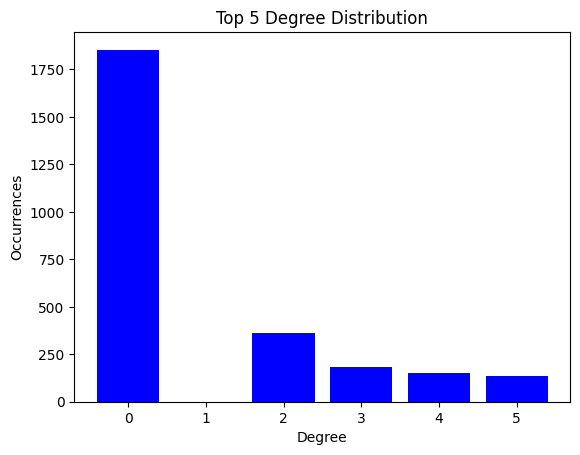

In [ ]:
# 创建柱状图
plt.bar(top_degrees, top_counts, color='blue', align='center')

# 添加标签和标题
plt.xlabel('Degree')
plt.ylabel('Occurrences')
plt.title('Top 5 Degree Distribution')

# 显示图形
plt.show()

In [ ]:
G = Hypergraph(5, [(0,1),(2,1),(3,4)])
G

Hypergraph(num_v=5, num_e=3)

In [ ]:
G.H

tensor(indices=tensor([[0, 1, 1, 2, 3, 4],
                       [0, 0, 1, 1, 2, 2]]),
       values=tensor([1., 1., 1., 1., 1., 1.]),
       size=(5, 3), nnz=6, layout=torch.sparse_coo)

In [ ]:
A = G.H @ G.H.T
A

tensor(indices=tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
                       [1, 0, 2, 1, 0, 2, 1, 4, 3, 4, 3]]),
       values=tensor([1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.]),
       size=(5, 5), nnz=11, layout=torch.sparse_coo)

In [ ]:
# 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# 计算每个节点的度
degree_list = adj_matrix.to_dense().sum(dim=1)
degree_list = degree_list.cpu().numpy().tolist()
degree_list

[2.0, 4.0, 2.0, 2.0, 2.0]